In [1]:
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()

In [ ]:
def same_seed(seed):
    '''
    Fixes random number generator seeds for reproducibility'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

same_seed(123)

In [2]:
HOME = os.path.expanduser('~')
NEWS_DATA_DIR = "Projects/Datasets/public_news_set"
IMAGE_DATA_DIR = "Projects/Datasets/public_image_set"
TRAIN_FILE = "multimodal_train_cleaned_sample.tsv"
TEST_FILE = "multimodal_test_cleaned_sample.tsv"
VALID_FLIE = "multimodal_valid_cleaned_sample.tsv"
DATADIRS = [TRAIN_FILE, TEST_FILE, VALID_FLIE]
SUFFIX = '.jpg'

LABEL2ID = {0: "True", 1: "Satire/Parody", 2: "Misleading Content", 3: "Imposter", 4: "False connection", 5: "Manipulated Content"}
LABELS = [LABEL2ID[i] for i in range(6)]
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
mid_train = pd.read_csv(os.path.join(HOME, NEWS_DATA_DIR, TRAIN_FILE), sep='\t')
mid_test = pd.read_csv(os.path.join(HOME, NEWS_DATA_DIR, TEST_FILE), sep='\t')
mid_valid = pd.read_csv(os.path.join(HOME, NEWS_DATA_DIR, VALID_FLIE), sep='\t')
mid_train.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,jnoble50,red skull,1.553267e+09,NaN,True,ej4e1lj,https://i.imgur.com/eD7QGRM.jpg,b44rhx,NaN,58,psbattle_artwork,Red Skull,NaN,0,2,4
1,Gtash,cafe in bangkok with the cutest employees ever...,1.559911e+09,nynno.com,True,bxu2dd,https://external-preview.redd.it/MS7vkNibB3Yq1...,NaN,0.0,34,upliftingnews,Cafe in Bangkok With the Cutest Employees Ever...,0.78,1,0,0
2,RoyalPrinceSoldier,he betrayed him,1.400820e+09,NaN,True,chp14h4,http://i.imgur.com/9Q9CCDn.jpg,269qyi,NaN,8,psbattle_artwork,He betrayed him!,NaN,0,2,4
3,penguinseed,alderman wants to know exactly what bong shops...,1.403114e+09,dnainfo.com,True,28h8p1,https://external-preview.redd.it/lwbRUIzyGF5sU...,NaN,2.0,3,nottheonion,Alderman Wants to Know Exactly What 'Bong Shop...,0.71,1,0,0
4,DM90,man accused of stalking scots police officer s...,1.383750e+09,dailyrecord.co.uk,True,1q10us,https://external-preview.redd.it/_fNXvGtKcKn_U...,NaN,2.0,23,nottheonion,Man accused of stalking Scots police officer s...,0.84,1,0,0


In [4]:
im = Image.open(os.path.join(HOME, IMAGE_DATA_DIR, mid_train.id[3] + SUFFIX))
np.asarray(im).shape

(214, 320, 3)

In [5]:
# check the error image count
min_w = float("inf") 
min_h = float("inf")
max_w = 0
max_h = 0
e_count = 0
for i in range(len(mid_test)):    
    im = Image.open(os.path.join(HOME, IMAGE_DATA_DIR, mid_test.id[i] + ".jpg"))
    if im.size[0] > max_h:
        max_h = im.size[0]
    if im.size[1] > max_w:
        max_w = im.size[1]
    if im.size[0] < min_h:
        min_h = im.size[0]
    if im.size[1] < min_w:
        min_w = im.size[1]

min_w, min_h, max_w, max_h, e_count

(29, 108, 6396, 8400, 0)

## resize image to fit model need

In [6]:
import transformers

# transform the train data
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# transform the test and validate data
transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
def load_trans(filepath, train=True):
    im = Image.open(filepath)
    # print(np.asarray(im).shape)
    # print(filepath)
    if im.mode != "RGB":
        im = im.convert(mode="RGB")
    im_trans = transform_train(im) if train else transform_val(im)
    return im_trans

In [8]:
class ImgDataset(Dataset):
    def __init__(self, df, train=True) -> None:
        super().__init__()
        self.df = df
        self.train = train
        df.dtype = np.float64
        self.labels = df['6_way_label'].values
        self.ids = df['id'].values

    def __getitem__(self, idx):
        img_path = os.path.join(HOME, IMAGE_DATA_DIR, self.df.id[idx] + SUFFIX)
        img_tensor = load_trans(img_path, self.train)
        label = self.labels[idx]
        return img_tensor, label

    def __len__(self):
        return len(self.labels)


In [9]:
mid_train_dataset = ImgDataset(mid_train)
train_dataloader = DataLoader(mid_train_dataset, batch_size=16)
mid_test_dataset = ImgDataset(mid_test, train=False)
test_dataloader = DataLoader(mid_test_dataset, batch_size=16)
mid_valid_dataset = ImgDataset(mid_valid, train=False)
valid_dataloader = DataLoader(mid_valid_dataset, batch_size=16)

dataloaders = {'train': train_dataloader, 'val': valid_dataloader}
dataset_sizes = {'train': len(mid_train_dataset), 'val': len(mid_valid_dataset)}

In [10]:
im = Image.open('/home/yangu/Projects/Datasets/public_image_set/ctdk4x3.jpg')
# im.convert(mode='RGB')

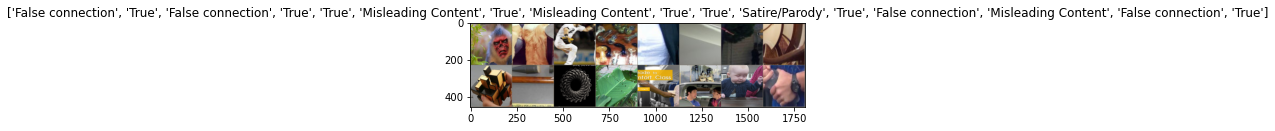

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[LABEL2ID[x] for x in classes.tolist()])

In [12]:
# fine-tune model
# fine-tune ResNet50
# model_ft = models.resnet50(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 6)

# fine-tune VGG-16
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[6].out_features = 6
model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.classifier.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [13]:
# train model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {LABEL2ID[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


  1%|          | 55/6822 [00:17<27:06,  4.16it/s] /home/yangu/miniconda3/envs/th_env/lib/python3.10/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 92%|█████████▏| 6268/6822 [30:14<02:28,  3.73it/s]/home/yangu/miniconda3/envs/th_env/lib/python3.10/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (110718270 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 6822/6822 [32:59<00:00,  3.45it/s]


train Loss: 1.0994 Acc: 0.6033


100%|██████████| 853/853 [02:45<00:00,  5.16it/s]


val Loss: 0.9080 Acc: 0.6668

Epoch 1/4
----------


100%|██████████| 6822/6822 [32:35<00:00,  3.49it/s]


train Loss: 0.9704 Acc: 0.6393


100%|██████████| 853/853 [02:38<00:00,  5.37it/s]


val Loss: 0.8788 Acc: 0.6790

Epoch 2/4
----------


100%|██████████| 6822/6822 [32:12<00:00,  3.53it/s]


train Loss: 0.9391 Acc: 0.6523


100%|██████████| 853/853 [02:38<00:00,  5.38it/s]


val Loss: 0.8618 Acc: 0.6859

Epoch 3/4
----------


100%|██████████| 6822/6822 [32:15<00:00,  3.53it/s]


train Loss: 0.9166 Acc: 0.6601


100%|██████████| 853/853 [02:38<00:00,  5.38it/s]


val Loss: 0.8443 Acc: 0.6911

Epoch 4/4
----------


100%|██████████| 6822/6822 [32:27<00:00,  3.50it/s]


train Loss: 0.8982 Acc: 0.6665


100%|██████████| 853/853 [02:38<00:00,  5.38it/s]

val Loss: 0.8358 Acc: 0.6944

Training complete in 175m 50s
Best val Acc: 0.694444


In [16]:
# TODO: save image model for VGG16 and ResNet50
torch.save(model_ft, 'vgg16_ft.pt')

In [ ]:
# test read file from zip file
import io
import tarfile

tar = tarfile.open('/home/yangu/Downloads/public_images.tar.bz2', 'r:bz2')
t = tar.getmember('public_image_set/chu0hgb.jpg')
te = tar.extractfile(t).read()
Image.open(io.BytesIO(te))

## Vision Transformer

In [4]:
from transformers import ViTFeatureExtractor, ViTModel, ViTForImageClassification
from datasets import load_dataset
from datasets import load_metric

num_labels = 6
model_ckpt = "google/vit-base-patch16-224-in21k"

In [5]:
feature_extractor = ViTFeatureExtractor(model_ckpt)
model = ViTForImageClassification.from_pretrained(model_ckpt, num_labels=num_labels)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [7]:
# Pre-process the iamge data
feature_extractor = ViTFeatureExtractor(model_ckpt)

def feature_extract(filepath):
    im = Image.open(filepath)
    if im.mode != "RGB":
        im = im.convert(mode="RGB")
    im_trans = feature_extractor(im, return_tensors='pt')
    return im_trans

class VitImgDataset(Dataset):
    def __init__(self, df, train=True) -> None:
        super().__init__()
        self.df = df
        self.train = train
        df.dtype = np.float64
        self.labels = df['6_way_label'].values
        self.ids = df['id'].values

    def __getitem__(self, idx):
        img_path = os.path.join(HOME, IMAGE_DATA_DIR, self.df.id[idx] + SUFFIX)
        img_dict = feature_extract(img_path)
        label = self.labels[idx]
        img_dict['labels'] = label
        return img_dict

    def __len__(self):
        return len(self.labels)

In [8]:
mid_train_dataset = VitImgDataset(mid_train)
train_dataloader = DataLoader(mid_train_dataset, batch_size=32)
mid_test_dataset = VitImgDataset(mid_test, train=False)
test_dataloader = DataLoader(mid_test_dataset, batch_size=32)
mid_valid_dataset = VitImgDataset(mid_valid, train=False)
valid_dataloader = DataLoader(mid_valid_dataset, batch_size=32)

dataloaders = {'train': train_dataloader, 'val': valid_dataloader}
dataset_sizes = {'train': len(mid_train_dataset), 'val': len(mid_valid_dataset)}

In [9]:
from transformers import TrainingArguments

batch_size = 16
training_args = TrainingArguments(
    output_dir="./vit-base-beans",
    evaluation_strategy="epoch",
    num_train_epochs=4,
    fp16=True,
    logging_steps=len(mid_train_dataset) // batch_size,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    per_gpu_train_batch_size=batch_size,
    per_gpu_eval_batch_size=batch_size,
    push_to_hub=False,
    report_to='tensorboard',
)

In [10]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'].squeeze() for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [11]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=mid_train_dataset,
    eval_dataset=mid_valid_dataset,
    tokenizer=feature_extractor,
)
trainer.train()

Using amp half precision backend
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
/home/yangu/miniconda3/envs/th_env/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 109149
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27288
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a

  0%|          | 0/27288 [00:00<?, ?it/s]

/home/yangu/miniconda3/envs/th_env/lib/python3.10/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Saving model checkpoint to ./vit-base-beans/checkpoint-500
Configuration saved in ./vit-base-beans/checkpoint-500/config.json
Model weights saved in ./vit-base-beans/checkpoint-500/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-500/preprocessor_config.json
Deleting older checkpoint [vit-base-beans/checkpoint-2500] due to args.save_total_limit
/home/yangu/miniconda3/envs/th_env/lib/python3.10/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Saving model checkpoint to ./vit-base-beans/checkpoint-1000
Configuration saved in ./vit-base-beans/checkpoint-1000/config.json
Model weights saved in ./vit-base-beans/checkpoint-1000/pytorch_model.bin
Feature extractor saved in ./

{'loss': 0.9433, 'learning_rate': 0.0001500366461448256, 'epoch': 1.0}


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 13644
  Batch size = 8


  0%|          | 0/853 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'eval_loss': 0.809918224811554, 'eval_accuracy': 0.6967897977132805, 'eval_runtime': 168.5222, 'eval_samples_per_second': 80.963, 'eval_steps_per_second': 5.062, 'epoch': 1.0}


Saving model checkpoint to ./vit-base-beans/checkpoint-7000
Configuration saved in ./vit-base-beans/checkpoint-7000/config.json
Model weights saved in ./vit-base-beans/checkpoint-7000/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-7000/preprocessor_config.json
Deleting older checkpoint [vit-base-beans/checkpoint-6000] due to args.save_total_limit
/home/yangu/miniconda3/envs/th_env/lib/python3.10/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Saving model checkpoint to ./vit-base-beans/checkpoint-7500
Configuration saved in ./vit-base-beans/checkpoint-7500/config.json
Model weights saved in ./vit-base-beans/checkpoint-7500/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-7500/preprocessor_config.json
Deleting older checkpoint [vit-base-beans/checkpoint-6500] due to args.save_total_limit
Saving model checkpoint to ./vit-base-beans/checkpo

{'loss': 0.7252, 'learning_rate': 0.00010005863383172091, 'epoch': 2.0}


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 13644
  Batch size = 8


  0%|          | 0/853 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'eval_loss': 0.7269185781478882, 'eval_accuracy': 0.7331427733802404, 'eval_runtime': 168.2311, 'eval_samples_per_second': 81.103, 'eval_steps_per_second': 5.07, 'epoch': 2.0}


Saving model checkpoint to ./vit-base-beans/checkpoint-14000
Configuration saved in ./vit-base-beans/checkpoint-14000/config.json
Model weights saved in ./vit-base-beans/checkpoint-14000/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-14000/preprocessor_config.json
Deleting older checkpoint [vit-base-beans/checkpoint-13000] due to args.save_total_limit
/home/yangu/miniconda3/envs/th_env/lib/python3.10/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Saving model checkpoint to ./vit-base-beans/checkpoint-14500
Configuration saved in ./vit-base-beans/checkpoint-14500/config.json
Model weights saved in ./vit-base-beans/checkpoint-14500/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-14500/preprocessor_config.json
Deleting older checkpoint [vit-base-beans/checkpoint-13500] due to args.save_total_limit
/home/yangu/miniconda3/envs/th_env/lib/py

{'loss': 0.5066, 'learning_rate': 5.008795074758136e-05, 'epoch': 3.0}


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 13644
  Batch size = 8


  0%|          | 0/853 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'eval_loss': 0.7801440954208374, 'eval_accuracy': 0.739739079448842, 'eval_runtime': 164.8493, 'eval_samples_per_second': 82.766, 'eval_steps_per_second': 5.174, 'epoch': 3.0}


Saving model checkpoint to ./vit-base-beans/checkpoint-20500
Configuration saved in ./vit-base-beans/checkpoint-20500/config.json
Model weights saved in ./vit-base-beans/checkpoint-20500/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-20500/preprocessor_config.json
Deleting older checkpoint [vit-base-beans/checkpoint-19500] due to args.save_total_limit
Saving model checkpoint to ./vit-base-beans/checkpoint-21000
Configuration saved in ./vit-base-beans/checkpoint-21000/config.json
Model weights saved in ./vit-base-beans/checkpoint-21000/pytorch_model.bin
Feature extractor saved in ./vit-base-beans/checkpoint-21000/preprocessor_config.json
Deleting older checkpoint [vit-base-beans/checkpoint-20000] due to args.save_total_limit
/home/yangu/miniconda3/envs/th_env/lib/python3.10/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Saving model checkpoint to ./vit-base-bea

{'loss': 0.2441, 'learning_rate': 1.1726766344180592e-07, 'epoch': 4.0}


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
***** Running Evaluation *****
  Num examples = 13644
  Batch size = 8


  0%|          | 0/853 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 1.0355395078659058, 'eval_accuracy': 0.7338024039871005, 'eval_runtime': 164.5363, 'eval_samples_per_second': 82.924, 'eval_steps_per_second': 5.184, 'epoch': 4.0}
{'train_runtime': 9318.4694, 'train_samples_per_second': 46.853, 'train_steps_per_second': 2.928, 'train_loss': 0.6047566806385853, 'epoch': 4.0}


TrainOutput(global_step=27288, training_loss=0.6047566806385853, metrics={'train_runtime': 9318.4694, 'train_samples_per_second': 46.853, 'train_steps_per_second': 2.928, 'train_loss': 0.6047566806385853, 'epoch': 4.0})